In [1]:
import gw_detections_functions as gwfn
import quantum_matched_filter_functions as qmffn
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal
import numpy as np

In [2]:
ht = np.loadtxt('data/H-H1_GWOSC_4KHZ_R1-1126259447-32.txt', skiprows=3)
psd_data = np.loadtxt('data/GWTC1_GW150914_PSDs.dat', skiprows=1, usecols=[0,1])

In [3]:
fs = 4096
f_low = 20.
dt=1./fs
T = 32
df = 1./T
N = int(T*fs)
t = dt*np.arange(N)
f = df*np.arange(N//2 + 1)

In [4]:
T_new = 28
fs_new = 4096
dt_new = 1./fs_new
df_new = 1./T_new
N_new = int(T_new*fs)
t_new = dt*np.arange(N_new)
f_new = df_new*np.arange(N_new//2 + 1)

In [5]:
inv_psd_func = interp1d(psd_data[:,0],1.0/psd_data[:,1],kind='linear',fill_value=(0.0,0.0),bounds_error=False)
inv_psd = inv_psd_func(f)

In [6]:
ht_w = gwfn.whiten(ht,inv_psd,fs)

In [7]:
ht_wb = gwfn.highpass(ht_w,f_low,fs)

In [8]:
ht_wbc = ht_wb[fs*(T - T_new)//2:-fs*(T - T_new)//2]

In [9]:
inv_psd = inv_psd_func(f_new)

In [10]:
_, st_wbc = gwfn.make_template(35.6,30.6,fs_new,T_new,inv_psd)

In [11]:
snr = gwfn.get_snr(ht_wbc,st_wbc,fs_new)

In [12]:
print(np.max(snr))

17.94968560692533


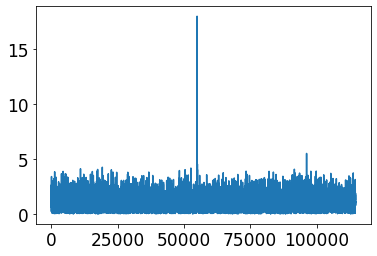

In [13]:
plt.plot(snr)

In [14]:
np.save('data/signal',ht_wbc)
np.save('data/psd', 1./inv_psd)

/home/fergus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


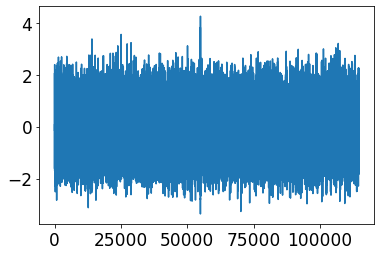

In [15]:
plt.plot(ht_wbc)

In [16]:
bank, _, _ = qmffn.get_paras(2**8)

In [17]:
m1s = bank['mass1']
m2s = bank['mass2']
s1s = bank['spin1z']
s2s = bank['spin2z']
fls = bank['f_lower']
paras = iter(np.array([m1s,m2s,s1s,s2s,fls]).T)

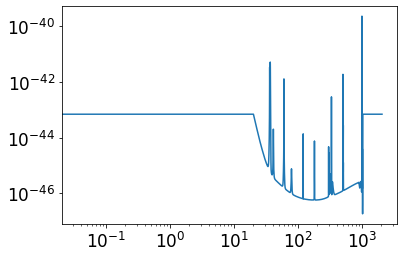

In [18]:
psd_func = interp1d(psd_data[:,0],psd_data[:,1],kind='linear',fill_value=(psd_data[0,1],psd_data[0,1]),bounds_error=False)
psd = psd_func(f_new)
plt.loglog(f_new,psd)

In [19]:
#noise_ = pycbc.noise.noise_from_psd(len(strain), strain.delta_t, psd_noise)

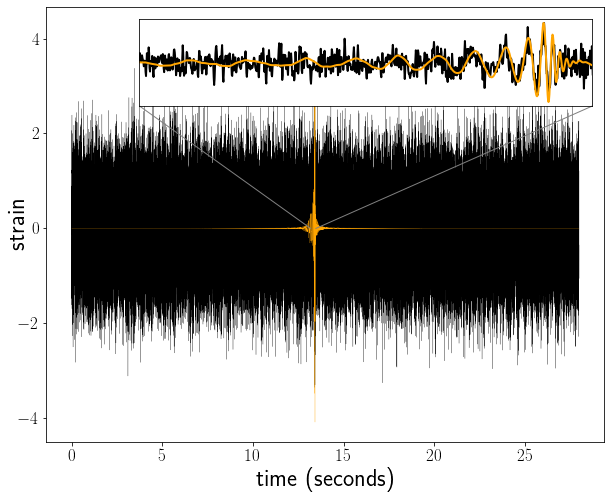

In [20]:
fontsize = 24
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif", 'size' : fontsize})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}'], 'size' : fontsize}
fig, ax = plt.subplots(figsize=(10,8))

temp = np.roll(st_wbc,np.argmax(ht_wbc)-np.argmax(st_wbc))

ax.plot(np.arange(len(ht_wbc))*dt,ht_wbc, color='black', lw=.2)
ax.plot(np.arange(len(ht_wbc))*dt,np.max(ht_wbc)*temp/np.max(st_wbc), color='orange', lw=.2)

ax.set_xlabel(r'time (seconds)', fontsize=fontsize)
ax.set_ylabel(r'strain', fontsize=fontsize, labelpad=-10)

axins = zoomed_inset_axes(ax, 100, loc=1)
axins.plot(np.arange(len(ht_wbc))*dt,ht_wbc/500, color='black', lw=2)
axins.plot(np.arange(len(ht_wbc))*dt,np.max(ht_wbc)*temp/(500*np.max(st_wbc)), color='orange', lw=2)
xmin, xmax = 13.2, 13.45
indmin, indmax = xmin/dt, xmax/dt
axins.set_xlim(xmin,xmax)
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

fig.savefig('../signal_zoom.png')

plt.show()

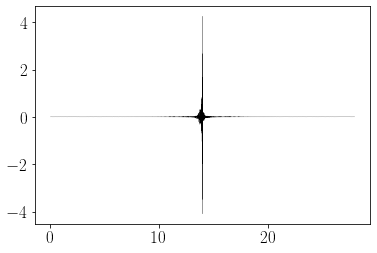

In [21]:
plt.plot(np.arange(len(ht_wbc))*dt,np.max(ht_wbc)*st_wbc/np.max(st_wbc), color='black', lw=.2)
plt.show()

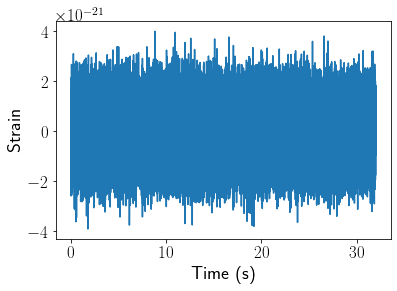

In [22]:
import pycbc.noise
import pycbc.psd
import pylab

# The color of the noise matches a PSD which you provide
flen = int(2048 / df) + 1
noise_psd = pycbc.psd.aLIGOMidLowSensitivityP1200087(flen, df, f_low)

# Generate 32 seconds of noise at 4096 Hz
tsamples = int(32 / dt)
noise = pycbc.noise.noise_from_psd(tsamples, dt, noise_psd)

pylab.plot(noise.sample_times, noise)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

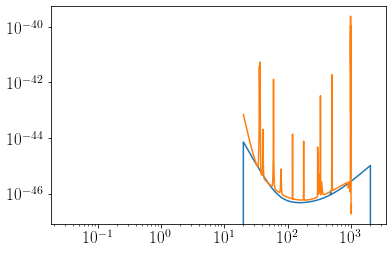

In [23]:
plt.loglog(noise_psd.sample_frequencies,noise_psd)
plt.loglog(psd_data[:,0],psd_data[:,1])

plt.show()

In [24]:
inv_noise_psd_func = interp1d(noise_psd.sample_frequencies,1.0/np.array(noise_psd),kind='linear',fill_value=(0.0,0.0),bounds_error=False)
inv_noise_psd = inv_noise_psd_func(f)
inv_noise_psd = np.where(inv_noise_psd==np.inf, 0., inv_noise_psd)

/home/fergus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [25]:
print(inv_psd)
print(inv_noise_psd)

[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.78279198e+44
 9.78250404e+44 0.00000000e+00]


In [26]:
noise_w = gwfn.whiten(np.array(noise),inv_noise_psd,fs)

In [27]:
noise_wb = gwfn.highpass(noise_w,f_low,fs)

In [28]:
noise_wbc = noise_wb[fs*(T - T_new)//2:-fs*(T - T_new)//2]

In [29]:
inv_noise_psd_new = inv_noise_psd_func(f_new)
inv_noise_psd_new = np.where(inv_noise_psd_new==np.inf, 0., inv_noise_psd_new)

In [30]:
_, st_wbc = gwfn.make_template(35.6,30.6,fs_new,T_new,inv_noise_psd_new)

In [31]:
snr = gwfn.get_snr(noise_wbc,st_wbc,fs_new)
print(np.max(snr))

5.035557927816317


In [32]:
np.save('data/noise',noise_wbc)
np.save('data/noise_psd', 1./inv_noise_psd_new)

/home/fergus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
